author: @SteveEckel

This script shows examples about how to solve for the dynamics of a 1D MOT and
calculate things like the capture velocity.  We will deal specifically with a 1D MOT.
We can compare results to those of 1 D. Haubrich, A. Höpe, and D. Meschede, “A simple model for optical capture of atoms in strong magnetic quadrupole fields” _Optics Communications_ __102__, 225 (1993).  http://dx.doi.org/10.1016/0030-4018(93)90387-K

In this example, we will mostly focus on the heuristic force equation for an $F=0\rightarrow F'=1$ atom in a magnetic field:

$$
F = \frac{\hbar k \Gamma}{2}\sum_{q,i} \frac{\beta_i (\epsilon_q \cdot \hat{B}(r))^2}{1+\sum_j\beta_j + 4[\Delta - \mathbf{k}_i\cdot \mathbf{v} - q \mu_B B(r)/\hbar]^2/\Gamma^2}
$$

where $F$ is the force, $\Gamma$ is the decay, $q=-1,0,1$, $\beta_i$ and $\mathbf{k}_i$ are the intensity and wavevector of the $i$th laser beam (which can depend on time $t$ and position $\mathbf{r}$.  This equation is encoded in `pylcp.heuristiceq`. 

We'll use the standard 3D MOT quadrupole field,

$$
\mathbf{B} = B'\left(-\frac{1}{2}(x\hat{x} + y\hat{y})+z\hat{z}\right)
$$

where $B'$ is the magnetic field gradient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy.constants as cts
import pylcp
import pylcp.atom as atom
from pylcp.fields import conventional3DMOTBeams
from pylcp.common import bisectFindChangeValue, progressBar
#plt.style.use('paper')

### Let's now set up the units:
As with any problem in `pylcp`, the units that one chooses are arbitrary.  We will denote all explicit units with a subscript and all quantities where we have removed the units with an overbar, e.g. $\bar{x} = x/x_0$.  Our choice in this script will be different from the default choices of $x_0=1/k$ and $t_0 =1/\Gamma$.  Instead, let's choose units where the force is given by (along the $\hat{z}$ axis):

$$
\bar{\mathbf{F}} = \frac{\hat{\mathbf{k}}}{2}\sum_{q,i}\frac{\beta_i (\epsilon_q \cdot \hat{B}(r))^2}{1+\sum_j\beta_j + 4(\delta - \hat{\mathbf{k}}_i\cdot \mathbf{\bar{v}} - q \bar{z})^2}
$$

where $\delta = \Delta/\Gamma$.  This is equivalent the above equation by setting $k/\Gamma=1$ and $\mu_B B'/(\hbar \Gamma)=1$.  Or, in other words, we want a unit system that measures velocities in terms of $\Gamma/k$, positions in terms of $\hbar \Gamma/\mu_B B'$, and forces in terms of $\hbar k \Gamma$.

Programmatically, it allows us to just specify the _unit_ vector for $\mathbf{k}$ when we program `laserBeams`, set the magnetic field gradient parameter $\alpha=1$, and set $\Gamma=1$ ($\hbar=1$ by default).

So what are the length and time units of this system?  Well, the length unit is given by $x_0 = \hbar \Gamma/\mu_B B'$ and $t_0$ is defined such that

$$
\bar{v} = \frac{k v}{\Gamma}  = k \frac{x_0}{\Gamma t_0}\bar{v}
$$

implying that

$$
t_0 = \frac{k x_0}{\Gamma}
$$

Plugging in the numbers,

In [2]:
# 50 gauss/cm for Sr 
# mub on database
# 0.43 cm for x0 30/1.4/50

x0 = (30/1.4/50) # cm
k = 2*np.pi/461E-7 # cm^{-1}
kbar = k*x0

gamma = 2*np.pi*30e6
t0 = k*x0/gamma
wb = .47/x0
print(x0, k, kbar, 1/gamma, t0, wb)

0.4285714285714286 136294.69212970903 58412.01091273245 5.305164769729845e-09 0.0003098853424233034 1.0966666666666665


Finally, we need the mass, which is defined through the prefactor to the force equation.  We'll factor out the magnitude of the $\mathbf{k}$ vector because :

$$
\ddot{\mathbf{r}} = \frac{\mathbf{F}}{m} = \frac{\hbar k \Gamma}{m}\hat{\mathbf{k}}
$$

Note that I neglected the sum, since that is dimensionless already.  I can now put in the units explicitly:

$$
\frac{x_0}{t_0^2} \ddot{\bar{\mathbf{r}}} = \frac{\hbar k \Gamma }{m}\hat{\mathbf{k}}
$$

Rearranging,

$$
\ddot{\bar{\mathbf{r}}} = \frac{\hbar k \Gamma t_0^2}{m x_0} \hat{\mathbf{k}} = \frac{\hbar k^2 t_0}{m}\hat{\mathbf{k}} = \frac{\bar{\mathbf{F}}}{\bar{m}}
$$

where $\bar{m} = m/(\hbar k^2 t_0)$.

Note that the mass of Rb atom is 86.909180527 u.

In [3]:
mass = 86.909180527*cts.value('atomic mass constant')/(cts.hbar*(k*1e2)**2*t0)
print(mass)

#print(pylcp.laserBeams.__doc__) # Use this to test

0.023772763551430615


### First, we define the simple problem:

In [4]:
# Set up the laser beams with their appropriate characteristics

det = -1.5
alpha = 1.0
beta = 1.0

#laserBeams = pylcp.laserBeams([
#    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'beta':beta, 'delta':det},
#    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'beta':beta, 'delta':det},
#    {'kvec':np.array([ 1., 0., 0.]), 'pol':-1, 'beta':beta, 'delta':det},
#    {'kvec':np.array([-1., 0., 0.]), 'pol':-1, 'beta':beta, 'delta':det},
#    {'kvec':np.array([0.,  1., 0.]), 'pol':-1, 'beta':beta, 'delta':det},
#    {'kvec':np.array([0., -1., 0.]), 'pol':-1, 'beta':beta, 'delta':det}],
#    beam_type=pylcp.guassianBeam
#)
# rs is like radius for clipped sharp beams
laserBeams = conventional3DMOTBeams(beta=beta, delta=det, beam_type=pylcp.clippedGaussianBeam, wb=wb*1000, rs=wb)

magField = pylcp.quadrupoleMagneticField(alpha)

heuristic = pylcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)

### Now compute the background force profile:

In [5]:
# Create the forces

dz = 0.1
dv = 0.1
z = np.arange(-20, 20+dz, dz)
v = np.arange(-20, 20+dv, dv)

Z, V = np.meshgrid(z, v)

# Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z]) Changed when X = Y = 0
# Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

Rfull = np.array([Z, Z, Z])
Vfull = np.array([V, V, V])

heuristic.generate_force_profile(Rfull, Vfull, name='Fz')

Plot 'er up:

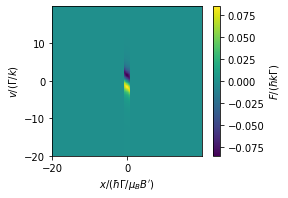

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.75))
plt.imshow(heuristic.profile['Fz'].F[2], origin='bottom',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2))
cb1 = plt.colorbar()
cb1.set_label('$F/(\hbar k \Gamma)$')
ax.set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

#fig.savefig()

In [7]:
heuristic.profile['Fz'].F[2] # Debug

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Now, let's add in trajectories in phase space:

The first thing to do is define a stop condition, when the velocity of the atom gets to be too small.

In [8]:
# Define when the program stops and also describes the trajectories. Sets the initial motion/velocity and then evolves the motion

v0s = np.arange(1, 10.5, 1)

# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-5):
    if np.linalg.norm(y[-6:-3])<threshold  and np.linalg.norm(y[-3:])<1e-3:
        val = -1.
    else:
        val = 1.
    
    return val

def lost_condition(t, y, threshold=1e-5):
    if np.linalg.norm(y[-3:])>20.:
        val = -1.
    else:
        val = 1.
    
    return val

captured_condition.terminal=True
lost_condition.terminal=True

sols = []
for v0 in v0s:
    heuristic.set_initial_position_and_velocity(-19.*((np.array([1., 1., 1.])/(3**0.5))),
                                                v0*(np.array([1., 1., 1.])/(3**0.5)))
    heuristic.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1)
    
    sols.append(heuristic.sol)

Now, plot it up:

(-20, 20)

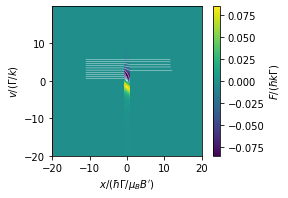

In [9]:
# Phase diagrams are only useful right now in certain axises
fig, ax = plt.subplots(1, 1, figsize=(4, 2.75))
plt.imshow(heuristic.profile['Fz'].F[2], origin='bottom',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2))
cb1 = plt.colorbar()
cb1.set_label('$F/(\hbar k \Gamma)$')
ax.set_xlabel('$x/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols:
    ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

# Display the figure at the end of the thing.
ax.set_xlim((-20, 20))
ax.set_xlim((-20, 20))

By having two conditions, we can tell if the atom was lost or captured:

In [10]:
for sol in sols:
    if len(sol.t_events[0]) == 1:
        print('captured')
    elif len(sol.t_events[1]) == 1:
        print('lost')

captured
captured
captured
captured
captured
lost
lost
lost
lost
lost


### Now, let's get even more fancy:

Let's define a function that figures out if we were captured or not, then use that to find the capture velocity:

In [11]:
def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, **kwargs):
    eqn.set_initial_position_and_velocity(-19.*((np.array([1., 1., 1.])/(3**0.5))),
                                                v0*(np.array([1., 1., 1.])/(3**0.5)))
    eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                      **kwargs)
    
    return len(eqn.sol.t_events[0]) == 1

iscaptured(1, -19., heuristic, captured_condition, lost_condition, tmax=1000, max_step=0.1)

True

See if we can find out where it changes:

In [12]:
bisectFindChangeValue(iscaptured, 1.,
                      args=(-19., heuristic, captured_condition, lost_condition),
                      kwargs={'tmax':1000, 'max_step':0.1},
                      tol=1e-2
                     )

C:\Users\leow0\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\leow0\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(5.171875, 11)

### Let's run the detuning and intensity:

We will figure out how the capture velocity depends on and compare to this equation from the paper in the introduction:

$$
v_c = \left(\frac{a_0^2\beta^2\kappa}{(1+\beta)^{3/2}}\right)^{1/3}\left(\frac{8\pi\delta^2}{1+\beta+4\delta^2}\right)^{1/3}\zeta^{-2/3}
$$

where $a_0 = \hbar k \Gamma/(2 m)$, $\zeta = \mu_B B'/(\hbar\Gamma)$, and $\kappa = 2\pi/(\lambda \Gamma)=k/\Gamma$ .  To compare, we need to express it in a way which connects with our formulae above.  The first thing to note is that $\zeta = 1/x_0$.  We also need to multiple both sides by $k/\Gamma$, so that we have $v_c/(\Gamma/k)$ on the left side, which is our observable.  Then, we realize that

$$
\frac{\hbar k\Gamma}{2m} = \frac{1}{2\bar{m}}\frac{x_0}{t_0^2}~~~~~\text{and}~~~~~\frac{k}{\Gamma} = \frac{t_0}{x_0} 
$$

Putting it all together:

$$
\frac{v_c}{\Gamma/k} = \frac{t_0}{x_0}\left(\frac{1}{2\bar{m}}\right)^{2/3} \frac{x_0^{2/3}}{t_0^{4/3}}\frac{t_0^{1/3}}{x_0^{1/3}} x_0^{2/3}\left(\frac{\beta^2}{(1+\beta)^{3/2}}\right)^{1/3}\left(\frac{8\pi\delta^2}{1+\beta+4\delta^2}\right)^{1/3} = \left(\frac{1}{2\bar{m}}\right)^{2/3}\left(\frac{\beta^2}{(1+\beta)^{3/2}}\right)^{1/3}\left(\frac{8\pi\delta^2}{1+\beta+4\delta^2}\right)^{1/3}
$$

In [15]:
dets = -np.logspace(-0.6, np.log10(3), 10)[::-1]
betas = np.array([0.5,1.,2.])

DETS, BETAS = np.meshgrid(dets, betas)

it = np.nditer([DETS, BETAS, None, None])

progress = progressBar()
for (det, beta, vc, iterations) in it:
#    laserBeams = pylcp.laserBeams([
#        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]), 'beta':beta, 'delta':det},
#        {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]), 'beta':beta, 'delta':det}],
#        beam_type=pylcp.guassianBeam
#    )
    laserBeams = conventional3DMOTBeams(beta=beta, delta=det, beam_type=pylcp.clippedGaussianBeam, wb=wb*1000, rs=wb)

    heuristic = pylcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)
    
    vc[...], iterations[...] = bisectFindChangeValue(
        iscaptured, 1.,
        args=(-19, heuristic, captured_condition, lost_condition),
        kwargs={'tmax':1000, 'max_step':0.1},
        tol=1e-2
    )

    progress.update((it.iterindex+1)/it.itersize)

Completed in 5:59.                                                  


In [16]:
def vc_from_paper(delta, beta, mbar):
    return 1/(2*mbar)**(2./3.)*(beta**2/(1+beta)**(3./2.))**(1./3.)*(8*np.pi*delta**2/(1+beta+4*delta**2))**(1./3.)

Text(0, 0.5, '$v_c/(\\Gamma/k)$')

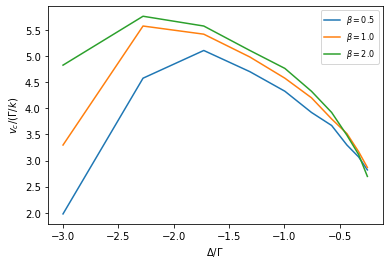

In [17]:
fig, ax = plt.subplots(1, 1)
for (beta, vc_vs_det) in zip(betas, it.operands[2]):
    ax.plot(dets, vc_vs_det, label='$\\beta=%.1f$' % beta)
ax.legend(fontsize=8)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$v_c/(\Gamma/k)$')